<a href="https://colab.research.google.com/github/anthony-anania/salaryprediction/blob/main/COMP_333.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team 15

Datasets - collections and system -


Our Prediction task:
We Are trying to predict the salary of MLB players based on their statistics of the 2023 season

Our 3 datasets:
https://databases.usatoday.com/major-league-baseball-salaries-2023/
For MLB players 2023 Salary and contracts

https://baseballsavant.mlb.com/leaderboard/statcast?type=batter&year=2023&position=&team=&min=1&sort=bip&sortDir=desc
For Exit Velocity statistics 2023


https://www.rotowire.com/baseball/stats.php?season=2023
For 2024 MLB Player Stats



Data Integration

Before we start anything we first need to have a plan

The commun elements that will be used to merge all 3 datasets toghether was the Player name. All 3 datasets had overlapping unique player names, the only issue is that we had to standerdize the spelling. We would first have to remove any accents , any special characters, and commas and finally we would have to have them all be in the format "first last". We would also have to deal with duplicate name (same player different team)

Beyond this we had to deal with null values. Nulls in exit table were removed if they did not have avr_exit since they did not record a hit during the season. The other nulls were filled using mean(), except for hr_distance which was set to 0 since the player did not record a hr.
For the Salary table any missing salary was replaced with the league minimum.
Nulls in contract length were replaced by 1, nulls in total salary were replaced by yearly salary. (it was only recording if years>2)



![image description](image_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Unidecode
import pandas as pd

#Our external storage, We are using google drive since it is the easiest to use with google collab


stats = '/content/drive/My Drive/MLB_2023-player-stats-Batters.csv'
exit = '/content/drive/My Drive/MLB_2023_exit_velocity.csv'
salary = '/content/drive/My Drive/MLB_2023_salary.csv'
# Load tables
table_stats = pd.read_csv(stats)
table_exit = pd.read_csv(exit)
table_salary = pd.read_csv(salary)
#check nulls
null_counts_stats = table_stats.isnull().sum()
null_counts_exit = table_exit.isnull().sum()
null_counts_salary = table_salary.isnull().sum()

print("Number of nulls per col in Stats \n"  , null_counts_stats)
print("Number of nulls per col in Exit \n", null_counts_exit)
print("Number of nulls per col in Salary \n", null_counts_salary)
# fixed extra cols , The dataset was flawed

columns_to_delete = ['Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 10']
table_salary = table_salary.drop(columns=columns_to_delete)
null_counts_salary = table_salary.isnull().sum()

#replace nulls in salary year by 1 since it didnt record years for contarcts of 1 year duration
column_name = 'Years'
table_salary[column_name].fillna(1, inplace=True)
null_counts_salary = table_salary.isnull().sum()

print("Number of nulls per col in Salary \n", null_counts_salary)

#just checking if table are being read right
num_rows1 = len(table_stats)
num_rows2 = len(table_exit)
num_rows3 = len(table_salary)
print("Number of rows in the dataset:", num_rows1,num_rows2,num_rows3)

#just to see where it messes up
print(table_exit['last_name, first_name'][:10])


#delete row that does not have values for hiy angle/hit speed in exit dataset
#if they dont have these stats it simply means that they dont have many attempts or any

table_exit = table_exit.dropna(subset=['avg_hit_angle'])

# fill in missing values of fbld and gb with mean of col *** We might use a different approach by grouping or 50% mean ?
def replace_nulls_with_mean(df, columns):
    for col in columns:
        col_mean = df[col].mean()
        df[col].fillna(col_mean, inplace=True)

# Columns to replace null values
columns_to_replace_nulls = ['fbld', 'gb']

# Replace null values in specified columns
replace_nulls_with_mean(table_exit, columns_to_replace_nulls)

# replace avr_hr_dist null with "0", since they did not record one
table_exit['avg_hr_distance'].fillna(0, inplace=True)

#check if nulls are replaced
null_counts_exit = table_exit.isnull().sum()
print("Number of nulls per col in Exit \n", null_counts_exit)


#now there are no more null values in all 3 datasets

#checking for duplicate names in the 3 datasets:
duplicate_names_stats = table_stats[table_stats.duplicated(subset=['Player'], keep=False)]
duplicate_names_exit = table_exit[table_exit.duplicated(subset=['last_name, first_name'], keep=False)]
duplicate_names_salary = table_salary[table_salary.duplicated(subset=['Player'], keep=False)]

print("duplicate names in stats \n" ,duplicate_names_stats)
print("duplicate names in exit \n" ,duplicate_names_exit)
print("duplicate names in salary \n" , duplicate_names_salary)

table_stats['names_stripped_lower'] = table_stats['Player'].str.strip().str.lower()

# Check for duplicate names in the 'names' column for the STATS DF
duplicate_names = table_stats[table_stats.duplicated(subset=['names_stripped_lower'], keep=False)]

if not duplicate_names.empty:
    print("Potential duplicate names found:")
    print(duplicate_names[['Player', 'names_stripped_lower']])
else:
    print("No potential duplicate names found.")
# creating fuction that combines duplicate names
#some col need to be sum, first or mean depending on the statistic.
#Since the original df is ordered by At Bat(more time played on that team)We will pick the first team.
#Age and position are the same so we can also pick first

agg_functions = {
    'Team': 'first',
    'Pos': 'first',
    'Age': 'first',
    'G': 'sum' ,
    'AB': 'sum',
    'R': 'sum',
    'H': 'sum',
    '2B': 'sum',
    '3B': 'sum',
    'HR': 'sum',
    'RBI': 'sum',
    'SB': 'sum',
    'CS': 'sum',
    'BB': 'sum',
    'SO': 'sum',
    'SH': 'sum',
    'SF': 'sum',
    'HBP': 'sum',
    'AVG': 'mean',
    'OBP': 'mean',
    'SLG': 'mean',
    'OPS': 'mean'

}

# Combine rows with duplicate names while applying aggregation functions
col_to_round = ['AVG','OBP','SLG','OPS']
combined_stats = table_stats.groupby('Player').agg(agg_functions).reset_index()
combined_stats[col_to_round] = combined_stats[col_to_round].round(3)
# Check for duplicate names in the 'names' column
combined_stats['names_stripped_lower'] = combined_stats['Player'].str.strip().str.lower()
duplicate_names = combined_stats[combined_stats.duplicated(subset=['names_stripped_lower'], keep=False)]

if not duplicate_names.empty:
    print("Potential duplicate names found: in Stats\n")
    print(duplicate_names[['Player', 'names_stripped_lower']])
else:
    print("No potential duplicate names found.")

#Duplicates in SALARY DF (pick the highest salary)
#since the dataset is already ordered in decending order of salary and for performance in the exit table,
#we can just pick the first occurance of the duplicated name and discard of the other
salary_unique = table_salary.drop_duplicates(subset='Player', keep='first')
exit_unique = table_exit.drop_duplicates(subset='last_name, first_name', keep='first')
duplicate_names_sal = salary_unique[salary_unique.duplicated(subset=['Player'], keep=False)]
duplicate_names_exit = exit_unique[exit_unique.duplicated(subset=['last_name, first_name'], keep=False)]

print("\nPotential duplicate names found: in Salary\n", duplicate_names_sal)
print("\nPotential duplicate names found: in Exit\n", duplicate_names_exit)

# In salary df we first replaced all the nulls with 1 ( 1 year contract ), now we have to replace all the "0" in total amount by the yearly salary
salary_unique.loc[salary_unique['Years'] == 1, 'Total Value'] = salary_unique.loc[salary_unique['Years'] == 1, 'Salary']
#print(salary_unique)

#just to see where it messes up
print("\nNames pre unidecode ", table_exit['last_name, first_name'][:10])


#to standardize the spelling we use unidecode to remove any accents on names of players , this is because the 2 other dbs do not contain them
from unidecode import unidecode

exit_unique.loc[:, 'last_name, first_name'] = exit_unique['last_name, first_name'].apply(unidecode)
print("\nNames after unidecode" , table_exit['last_name, first_name'][:10])



# save all 3 cleaned file to csv
combined_stats.to_csv('clean_stats.csv', index=False)
exit_unique.to_csv('clean_exit.csv', index=False)
salary_unique.to_csv('clean_salart.csv', index=False)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.9 MB/s eta 0:00:00
Number of nulls per col in Stats 
 Player    0
Team      0
Pos       0
Age       0
G         0
AB        0
R         0
H         0
2B        0
3B        0
HR        0
RBI       0
SB        0
CS        0
BB        0
SO        0
SH        0
SF        0
HBP       0
AVG       0
OBP       0
SLG       0
OPS       0
dtype: int64
Number of nulls per col in Exit 
 last_name, first_name      0
player_id                  0
attempts                   0
avg_hit_angle              1
anglesweetspotpercent      0
max_hit_speed              1
avg_hit_speed              1
ev50                       1
fbld                       8
gb                         9
max_distance               0
avg_distance               0
avg_hr_distance          113
ev95plus                   0
ev95percent                0
barrels                    0
brl_percent                0
brl_pa                     0
dtype: int64
Number of nulls per col i

<ipython-input-2-d698bafff10d>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].fillna(col_mean, inplace=True)
<ipython-input-2-d698bafff10d>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_exit['avg_hr_distance'].fillna(0, inplace=True)


To merge we first need to standardize the "Name" columns in each dataset to match (first, last)

In [ ]:
import pandas as pd

#import all 3 cleaned files
df1 = pd.read_csv('clean_stats.csv')
df2 = pd.read_csv('clean_exit.csv')
df3 = pd.read_csv('clean_salart.csv')

print("Player names before:\n ", df3['Player'].head(10))
#clean of any special chars such as *
df3['Player'] = df3['Player'].str.replace('*', '')

print("\nPlayer names after * deletion :\n ", df3['Player'].head(10))

#split the Name of the players into 2 seperate col calles LastN, and FirstN
df2[['LastName', 'FirstName']] = df2['last_name, first_name'].str.split(', ', expand=True)
df3[['LastName', 'FirstName','WTF']] = df3['Player'].str.split(', ', expand=True)



#fixed issue by simply dropping extra column
df3.drop(columns=['WTF'], inplace=True)

#Rename col so its standerdized
df2.rename(columns={'last_name, first_name': 'Player'}, inplace=True)

columns_to_display = ['Player', 'LastName', 'FirstName']  # Replace 'col1', 'col2', 'col3' with your column names

# Display the first 15 rows with specific columns
print("\nPlayer names Before reassembly: \n", df3.iloc[:15, df3.columns.isin(columns_to_display)])


#Concatenate FirstName and LastName columns with a space between them
df2['Player'] = df2['FirstName'] + ' ' + df2['LastName']
df3['Player'] = df3['FirstName'] + ' ' + df3['LastName']

print("\nPlayer names After reassembly: \n", df3['Player'].head(15))

# Drop the separate FirstName and LastName columns
df2.drop(['FirstName', 'LastName'], axis=1, inplace=True)
df3.drop(['FirstName', 'LastName'], axis=1, inplace=True)

#merge
# Merge df1 and df2 on the 'name' column  WE DO NOT WANT NULLS
merged_df = pd.merge(df1, df2, on='Player', how='inner')
print("\nPlayer names After Merge: \n", merged_df['Player'].head(15))
# Merge the result with df3 on the 'name' column WE DO NOT MIND NULLS
merged_df = pd.merge(merged_df, df3, on='Player', how='left')
merged_df.reset_index(drop=True, inplace=True)

#save as csv
merged_df.to_csv('merged_df.csv', index=False)

#Note that we used merge "inner" for the exit velocity df and "left" for the salary df
#This is because we wanted quality data, we wanted only players that had player stats and batting exit stats, for the salary it is simple.
#Every Player with a decent sized contract is well documented, this means that if a player has a null value in salary we can easily fill it with the league minimum.


Player names before:
  0          Scherzer, Max
1      Verlander, Justin
2           Judge, Aaron
3        Rendon, Anthony
4            Trout, Mike
5           Cole, Gerrit
6          Seager, Corey
7         Correa, Carlos
8         Arenado, Nolan
9    Strasburg, Stephen*
Name: Player, dtype: object

Player names after * deletion :
  0         Scherzer, Max
1     Verlander, Justin
2          Judge, Aaron
3       Rendon, Anthony
4           Trout, Mike
5          Cole, Gerrit
6         Seager, Corey
7        Correa, Carlos
8        Arenado, Nolan
9    Strasburg, Stephen
Name: Player, dtype: object

Player names Before reassembly: 
                 Player   LastName  FirstName
0        Scherzer, Max   Scherzer        Max
1    Verlander, Justin  Verlander     Justin
2         Judge, Aaron      Judge      Aaron
3      Rendon, Anthony     Rendon    Anthony
4          Trout, Mike      Trout       Mike
5         Cole, Gerrit       Cole     Gerrit
6        Seager, Corey     Seager      Corey
7

DEALING with nulls post merge


Showing null values in merged.csv 
              Player       Salary  Years   Total Value
0        AJ Pollock          NaN    NaN           NaN
1       Aaron Hicks  $10,785,714    7.0   $70,000,000
2       Aaron Judge  $40,000,000    9.0  $360,000,000
3   Abraham Almonte          NaN    NaN           NaN
4      Abraham Toro          NaN    NaN           NaN
5       Adam Duvall   $7,000,000    1.0    $7,000,000
6        Adam Engel   $1,000,000    1.0    $1,000,000
7      Adam Frazier   $8,000,000    1.0    $8,000,000
8      Adam Haseley          NaN    NaN           NaN
9   Adley Rutschman     $733,900    1.0      $733,900
10    Adolis Garcia     $747,760    1.0      $747,760
11      Akil Baddoo          NaN    NaN           NaN
12       Alan Trejo     $722,000    1.0      $722,000
13        Alec Bohm     $748,000    1.0      $748,000
14    Alec Burleson     $721,450    1.0      $721,450

After dealing with nulls 



              Player       Salary  Years   Total Value
0        AJ Pol

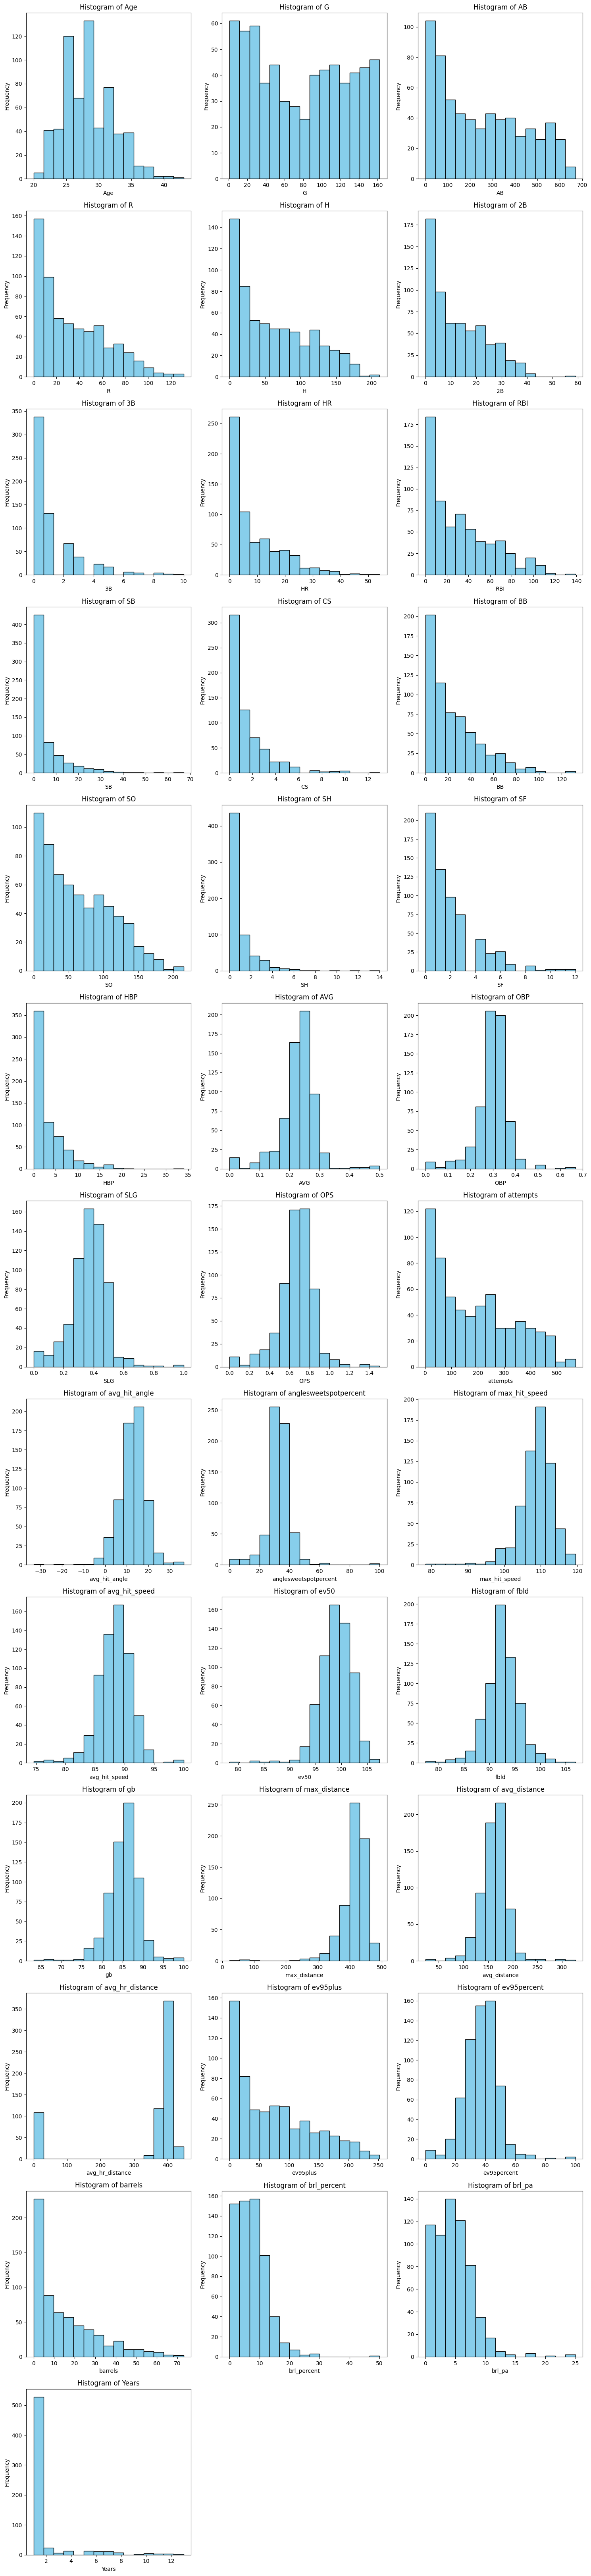

In [ ]:
import pandas as pd

merged_df = pd.read_csv('merged_df.csv')

columns_to_display = ['Player', 'Salary', 'Years', 'Total Value']

# Display the first 15 rows with specific columns
print("Showing null values in merged.csv \n" , merged_df.iloc[:15, merged_df.columns.isin(columns_to_display)])

MLB_MIN_Salary = 720000

merged_df['Salary'].fillna(MLB_MIN_Salary, inplace=True)
merged_df['Total Value'].fillna(MLB_MIN_Salary, inplace=True)
#we reapeat the same thing we did previously before merging.
merged_df['Years'].fillna(1, inplace=True)

formatted_specific_value = '${:,.0f}'.format(MLB_MIN_Salary)

# Replace specific_value with formatted_specific_value
merged_df['Salary'] = merged_df['Salary'].replace(MLB_MIN_Salary, formatted_specific_value)
merged_df['Total Value'] = merged_df['Total Value'].replace(MLB_MIN_Salary, formatted_specific_value)


#NOT NOW
#now we need to drop redundant columns/repeated
cols_to_drop = ['names_stripped_lower', 'player_id', 'Team_y','Position']

# Drop the columns
merged_df.drop(columns=cols_to_drop, inplace=True)
merged_df.to_csv('merged_clean.csv', index=False)
# Renaming cols so its more clear to us ***only show 4 cols and show prior to this change
print("\nAfter dealing with nulls \n\n\n\n" , merged_df.iloc[:15, merged_df.columns.isin(columns_to_display)])

import matplotlib.pyplot as plt
import seaborn as sns


def display_numeric_histograms(merged_df):
    numeric_columns = [col for col in merged_df.columns if col not in ['Player', 'Team_x' ,'player_id'] and merged_df[col].dtype in ['int64', 'float64']]

    num_rows = (len(numeric_columns) + 2) // 3
    num_cols = min(len(numeric_columns), 3)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

    if num_rows == 1 and num_cols == 1:
        axes = [axes]
    elif num_rows == 1:
        axes = axes.reshape(1, -1)
    elif num_cols == 1:
        axes = axes.reshape(-1, 1)

    for i, column in enumerate(numeric_columns):
        ax = axes[i // num_cols, i % num_cols]
        ax.hist(merged_df[column], bins=15, color='skyblue', edgecolor='black')
        ax.set_title(f'Histogram of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    for j in range(len(numeric_columns), num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])

    plt.tight_layout()
    plt.show()

display_numeric_histograms(merged_df)

**OUTLIER DETECTION**


In [ ]:
import numpy as np


def detect_outliers_by_column_zscore(df, columns, threshold):

    z_scores_df = pd.DataFrame(index=df.index)

    for column in columns:
        z_scores_df[column + '_ZScore'] = np.abs((df[column] - df[column].mean()) / df[column].std())

    is_outlier = z_scores_df.apply(lambda row: any(row > threshold), axis=1)

    df_filtered = df[~is_outlier]

    print("Number of outliers:", is_outlier.sum())

    return df_filtered

columns_of_interest = ["AVG", "OBP", "SLG", "OPS", "avg_hit_angle"]
improved_df_z = detect_outliers_by_column_zscore(merged_df, columns_of_interest, threshold=2.5)

print(improved_df_z)

Number of outliers: 39
             Player Team_x Pos  Age    G   AB   R    H  2B  3B  ...  \
1       Aaron Hicks    BAL  OF   34   93  269  44   68   9   1  ...   
2       Aaron Judge    NYY  OF   31  106  367  79   98  16   0  ...   
5       Adam Duvall    BOS  OF   35   92  320  45   79  24   2  ...   
7      Adam Frazier    BAL  2B   32  141  412  59   99  21   2  ...   
8      Adam Haseley    CWS  OF   27   28   36   6    8   2   0  ...   
..              ...    ...  ..  ...  ...  ...  ..  ...  ..  ..  ...   
626  Zach McKinstry    DET  2B   28  148  464  60  107  21   4  ...   
627       Zach Neto    LAA  SS   23   84  289  38   65  17   0  ...   
628  Zach Remillard    CWS  2B   30   54  147  16   37   7   0  ...   
630      Zack Gelof    OAK  2B   24   69  270  40   72  20   1  ...   
631      Zack Short    DET  2B   28  112  221  17   45   9   0  ...   

     Team_x_TEX  Team_x_TOR  Team_x_WAS  Pos_1B  Pos_2B  Pos_3B  Pos_C  \
1         False       False       False   False   

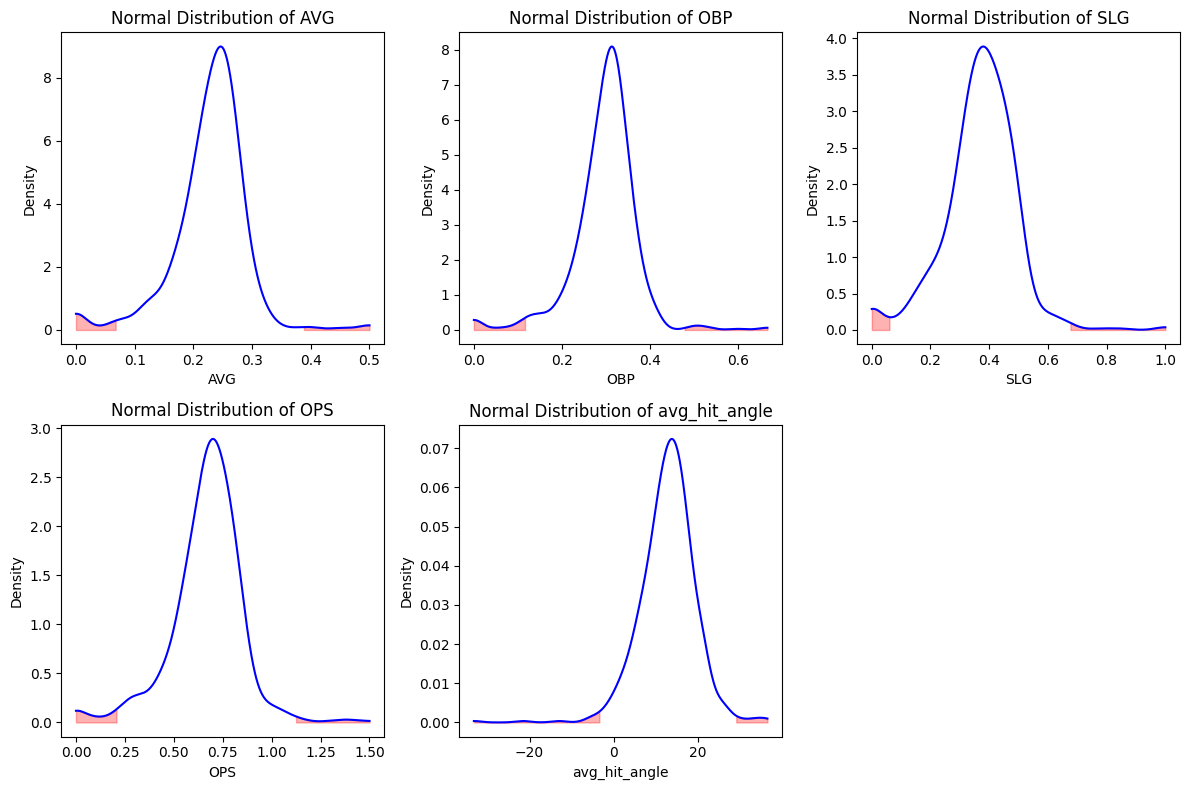

In [ ]:
#CODE FOR Z-SCORE DISPLAY (NORMAL DISTRIBUTION)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

columns_of_interest = ["AVG", "OBP", "SLG", "OPS", "avg_hit_angle"]
threshold = 2.5

plt.figure(figsize=(12, 8))
for column in columns_of_interest:
    plt.subplot(2, 3, columns_of_interest.index(column) + 1)

    kde = gaussian_kde(merged_df[column])
    x_vals = np.linspace(merged_df[column].min(), merged_df[column].max(), 1000)
    y_vals = kde(x_vals)


    plt.plot(x_vals, y_vals, color='blue')


    shade_region_left = merged_df[column].mean() - threshold * merged_df[column].std()
    shade_region_right = merged_df[column].mean() + threshold * merged_df[column].std()
    plt.fill_between(x_vals, 0, y_vals, where=(x_vals < shade_region_left), color='red', alpha=0.3)
    plt.fill_between(x_vals, 0, y_vals, where=(x_vals > shade_region_right), color='red', alpha=0.3)

    plt.title('Normal Distribution of ' + column)
    plt.xlabel(column)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [ ]:
def detect_outliers_by_iqr(df, columns, threshold):

    outlier_df = pd.DataFrame(index=df.index)


    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1


    for column in columns:
        lower_bound = Q1[column] - threshold * IQR[column]
        upper_bound = Q3[column] + threshold * IQR[column]

        outlier_df[column + '_Outlier'] = ((df[column] < lower_bound) | (df[column] > upper_bound))

    is_outlier = outlier_df.any(axis=1)

    df_filtered = df[~is_outlier]

    print("Number of outliers:", is_outlier.sum())

    return df_filtered

columns_of_interest = ["AVG", "OBP", "SLG", "OPS", "avg_hit_angle"]
improved_df_iqr = detect_outliers_by_iqr(merged_df, columns_of_interest, threshold=2.5)

Number of outliers: 30


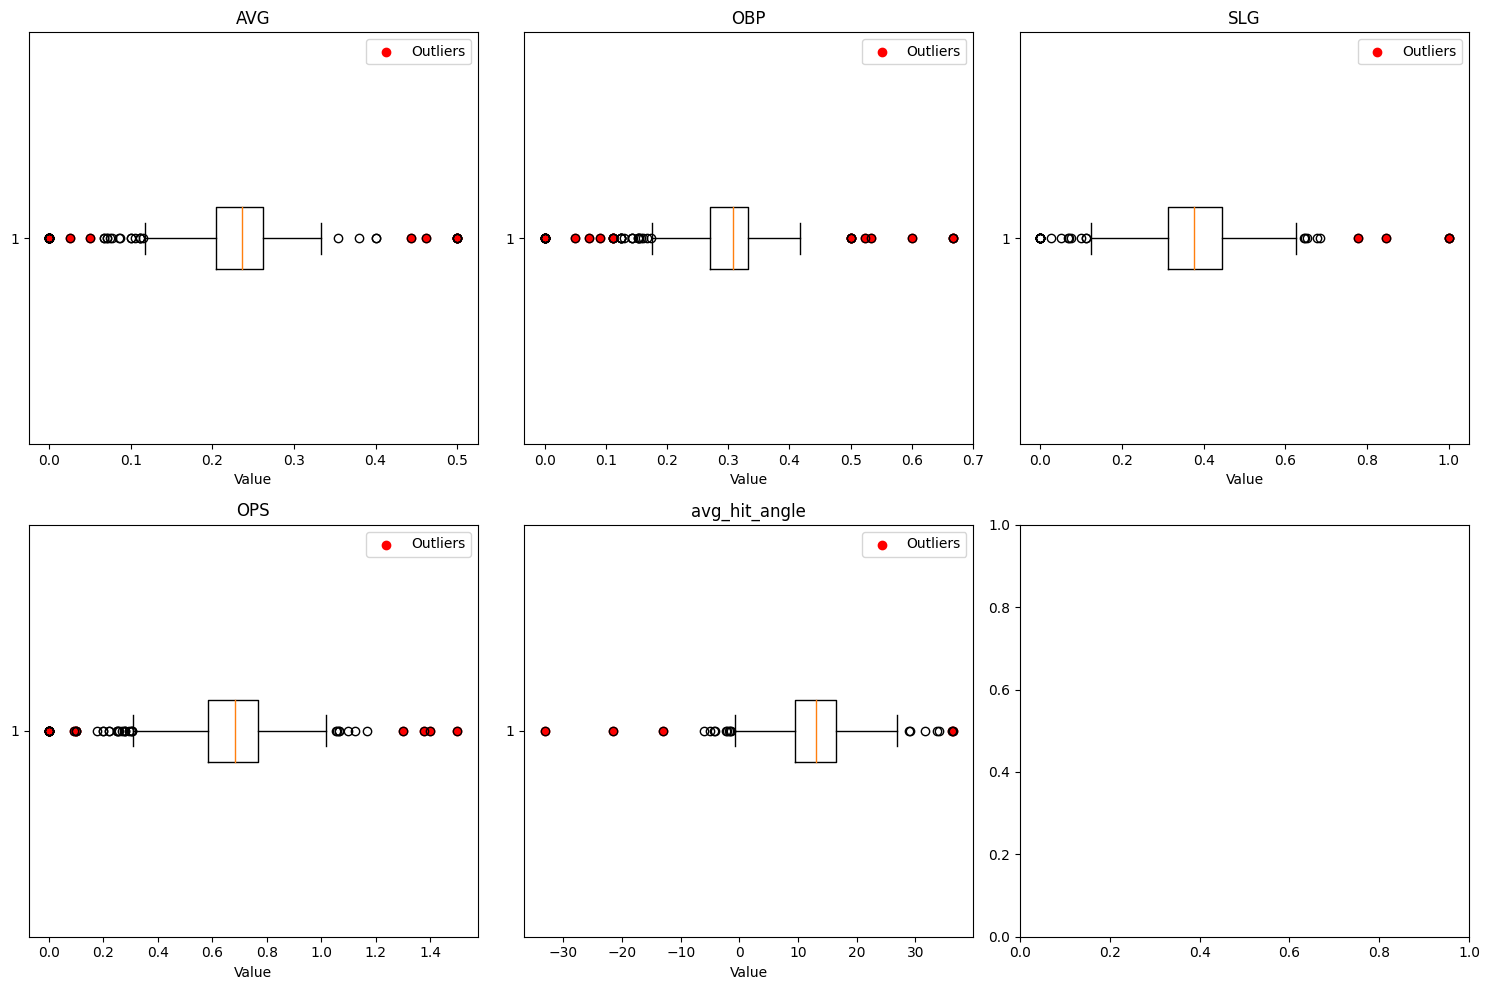

In [ ]:
#CODE FOR IQR DISPLAY


columns_to_test = ["AVG", "OBP", "SLG", "OPS", "avg_hit_angle"]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(columns_to_test):
    ax = axes[i]

    Q1 = merged_df[col].quantile(0.25)
    Q3 = merged_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2.5 * IQR

    outliers = merged_df[(merged_df[col] < lower_bound) | (merged_df[col] > upper_bound)][col]

    ax.boxplot(merged_df[col].dropna(), vert=False)

    if not outliers.empty:
        ax.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')

    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN

def detect_outliers_by_dbscan(df, columns, eps=0.5, min_samples=5):

    X = df[columns]

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X)

    is_outlier = dbscan.labels_ == -1

    df_filtered = df[~is_outlier]
    df_for_scan = df[is_outlier]
    print("Number of outliers:", is_outlier.sum())

    return df_filtered, df_for_scan

columns_of_interest = ["AVG", "OBP", "SLG", "OPS", "avg_hit_angle"]
improved_df_dbscan, df_for_scan = detect_outliers_by_dbscan(merged_df, columns_of_interest, eps=0.5, min_samples=5)




Number of outliers: 36


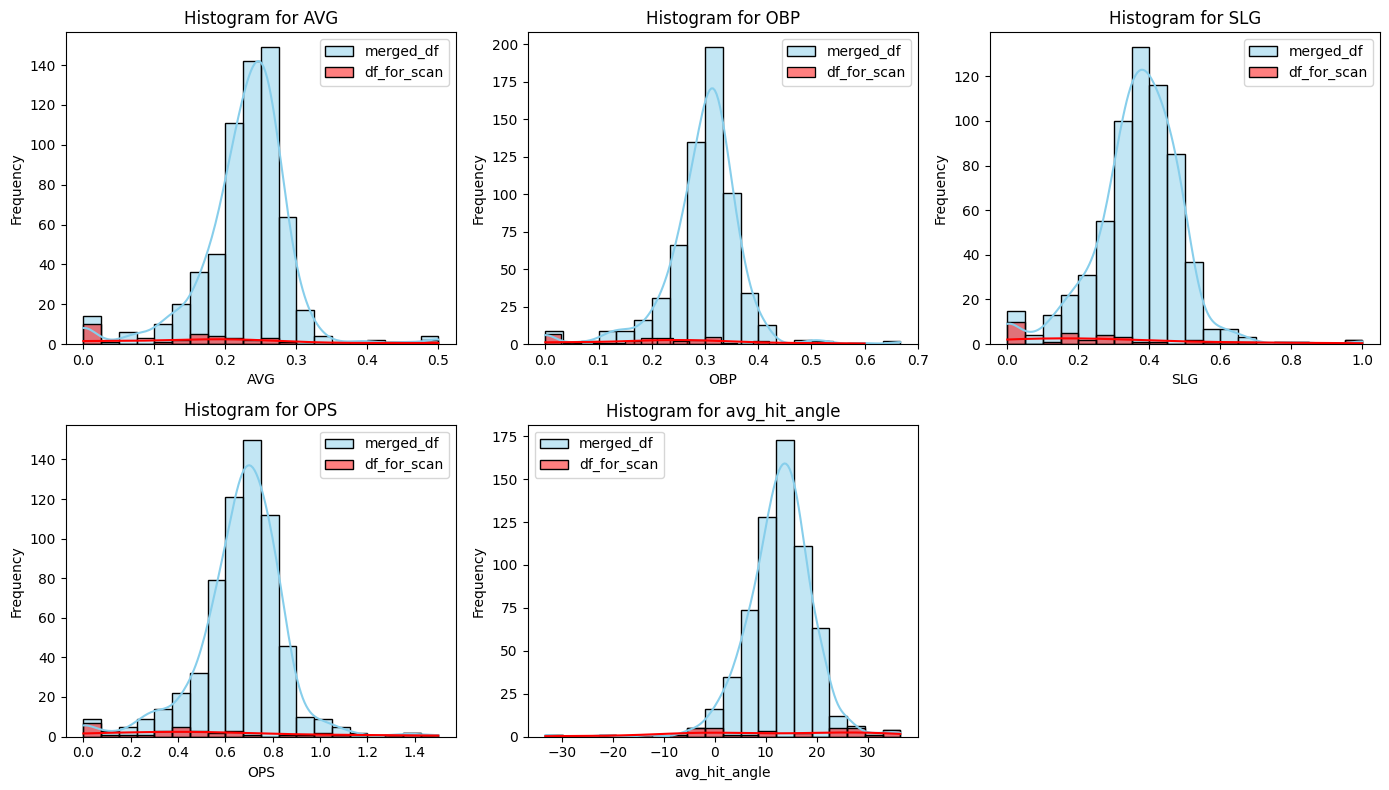

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_of_interest = ["AVG", "OBP", "SLG", "OPS", "avg_hit_angle"]

plt.figure(figsize=(14, 8))
for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(2, 3, i)

    sns.histplot(merged_df[column], bins=20, kde=True, color='skyblue', alpha=0.5, edgecolor='black', label='merged_df')
    sns.histplot(df_for_scan[column], bins=20, kde=True, color='red', alpha=0.5, edgecolor='black', label='df_for_scan')

    plt.title('Histogram for ' + column)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
#combining the records that made it past all tests
def filter_common_records(df1, df2, df3, common_column):

    merged_df = df1.merge(df2[[common_column]], on=common_column, how='inner')

    merged_df = merged_df.merge(df3[[common_column]], on=common_column, how='inner')

    return merged_df

common_column_name = 'Player'
filtered_df = filter_common_records(improved_df_z, improved_df_iqr, improved_df_dbscan, common_column_name)
#show the difference in dataset length
print(len(filtered_df))
print(filtered_df)
#drop outlier column

579
              Player Team_x Pos  Age    G   AB   R    H  2B  3B  ...  \
0        Aaron Hicks    BAL  OF   34   93  269  44   68   9   1  ...   
1        Aaron Judge    NYY  OF   31  106  367  79   98  16   0  ...   
2       Adam Frazier    BAL  2B   32  141  412  59   99  21   2  ...   
3       Adam Haseley    CWS  OF   27   28   36   6    8   2   0  ...   
4    Adley Rutschman    BAL   C   26  154  588  84  163  31   1  ...   
..               ...    ...  ..  ...  ...  ...  ..  ...  ..  ..  ...   
574   Zach McKinstry    DET  2B   28  148  464  60  107  21   4  ...   
575        Zach Neto    LAA  SS   23   84  289  38   65  17   0  ...   
576   Zach Remillard    CWS  2B   30   54  147  16   37   7   0  ...   
577       Zack Gelof    OAK  2B   24   69  270  40   72  20   1  ...   
578       Zack Short    DET  2B   28  112  221  17   45   9   0  ...   

     avg_distance  avg_hr_distance  ev95plus  ev95percent  barrels  \
0             143            387.0        59         29.4    

**NORMALIZATION**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalize_dataframe(df, exclude_columns):

    normalized_df = df.copy()

    columns_to_normalize = [col for col in df.columns if col not in exclude_columns]

    scaler = MinMaxScaler()

    normalized_data = scaler.fit_transform(normalized_df[columns_to_normalize])

    normalized_df[columns_to_normalize] = normalized_data

    return normalized_df


exclude_columns = ["Player", "Team_x", "Pos", "Age", "names_stripped_lower", "player_id",
                   "AVG", "OBP", "SLG", "Team_y", "Position",
                   "Salary", "Years", "Total Value"]

normalized_df = normalize_dataframe(filtered_df, exclude_columns)
print(normalized_df)

              Player Team_x Pos  Age         G        AB         R         H  \
0        Aaron Hicks    BAL  OF   34  0.566038  0.396084  0.335878  0.319048   
1        Aaron Judge    NYY  OF   31  0.647799  0.543675  0.603053  0.461905   
2       Adam Frazier    BAL  2B   32  0.867925  0.611446  0.450382  0.466667   
3       Adam Haseley    CWS  OF   27  0.157233  0.045181  0.045802  0.033333   
4    Adley Rutschman    BAL   C   26  0.949686  0.876506  0.641221  0.771429   
..               ...    ...  ..  ...       ...       ...       ...       ...   
574   Zach McKinstry    DET  2B   28  0.911950  0.689759  0.458015  0.504762   
575        Zach Neto    LAA  SS   23  0.509434  0.426205  0.290076  0.304762   
576   Zach Remillard    CWS  2B   30  0.320755  0.212349  0.122137  0.171429   
577       Zack Gelof    OAK  2B   24  0.415094  0.397590  0.305344  0.338095   
578       Zack Short    DET  2B   28  0.685535  0.323795  0.129771  0.209524   

           2B   3B  ...  avg_distance  

**HEAT MAP**

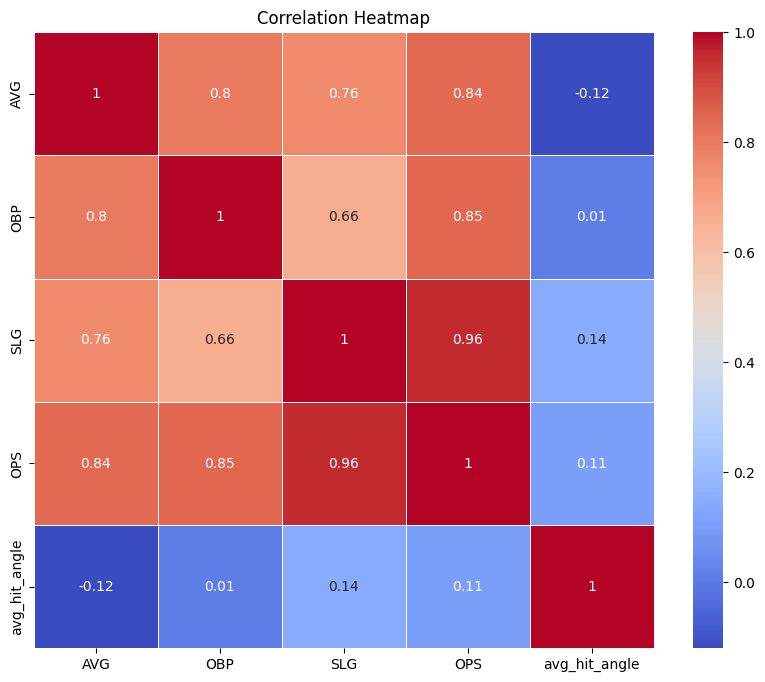

In [ ]:
columns_of_interest = ["AVG", "OBP", "SLG", "OPS", "avg_hit_angle"]

plt.figure(figsize=(10, 8))
sns.heatmap(normalized_df[columns_of_interest].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


**ENCODE CATEGORIES**

In [ ]:
encoded_df = pd.DataFrame(index=normalized_df.index)

encoded_df = pd.concat([encoded_df, pd.get_dummies(normalized_df['Team_x'], prefix='Team_x')], axis=1)
encoded_df = pd.concat([encoded_df, pd.get_dummies(normalized_df['Pos'], prefix='Pos')], axis=1)

merged_df_proper = pd.merge(normalized_df, encoded_df, left_index=True, right_index=True)

print(merged_df_proper)

#Encode for the data set that did not undergo outlier detection nor standardization for model accuracy comparisons
#DOWN BELOW
encoded_df = pd.DataFrame(index=merged_df.index)

encoded_df = pd.concat([encoded_df, pd.get_dummies(merged_df['Team_x'], prefix='Team_x')], axis=1)
encoded_df = pd.concat([encoded_df, pd.get_dummies(merged_df['Pos'], prefix='Pos')], axis=1)

merged_df= pd.merge(merged_df, encoded_df, left_index=True, right_index=True)

print(merged_df)

              Player Team_x Pos  Age         G        AB         R         H  \
0        Aaron Hicks    BAL  OF   34  0.566038  0.396084  0.335878  0.319048   
1        Aaron Judge    NYY  OF   31  0.647799  0.543675  0.603053  0.461905   
2       Adam Frazier    BAL  2B   32  0.867925  0.611446  0.450382  0.466667   
3       Adam Haseley    CWS  OF   27  0.157233  0.045181  0.045802  0.033333   
4    Adley Rutschman    BAL   C   26  0.949686  0.876506  0.641221  0.771429   
..               ...    ...  ..  ...       ...       ...       ...       ...   
574   Zach McKinstry    DET  2B   28  0.911950  0.689759  0.458015  0.504762   
575        Zach Neto    LAA  SS   23  0.509434  0.426205  0.290076  0.304762   
576   Zach Remillard    CWS  2B   30  0.320755  0.212349  0.122137  0.171429   
577       Zack Gelof    OAK  2B   24  0.415094  0.397590  0.305344  0.338095   
578       Zack Short    DET  2B   28  0.685535  0.323795  0.129771  0.209524   

           2B   3B  ...  Team_x_TEX  Te

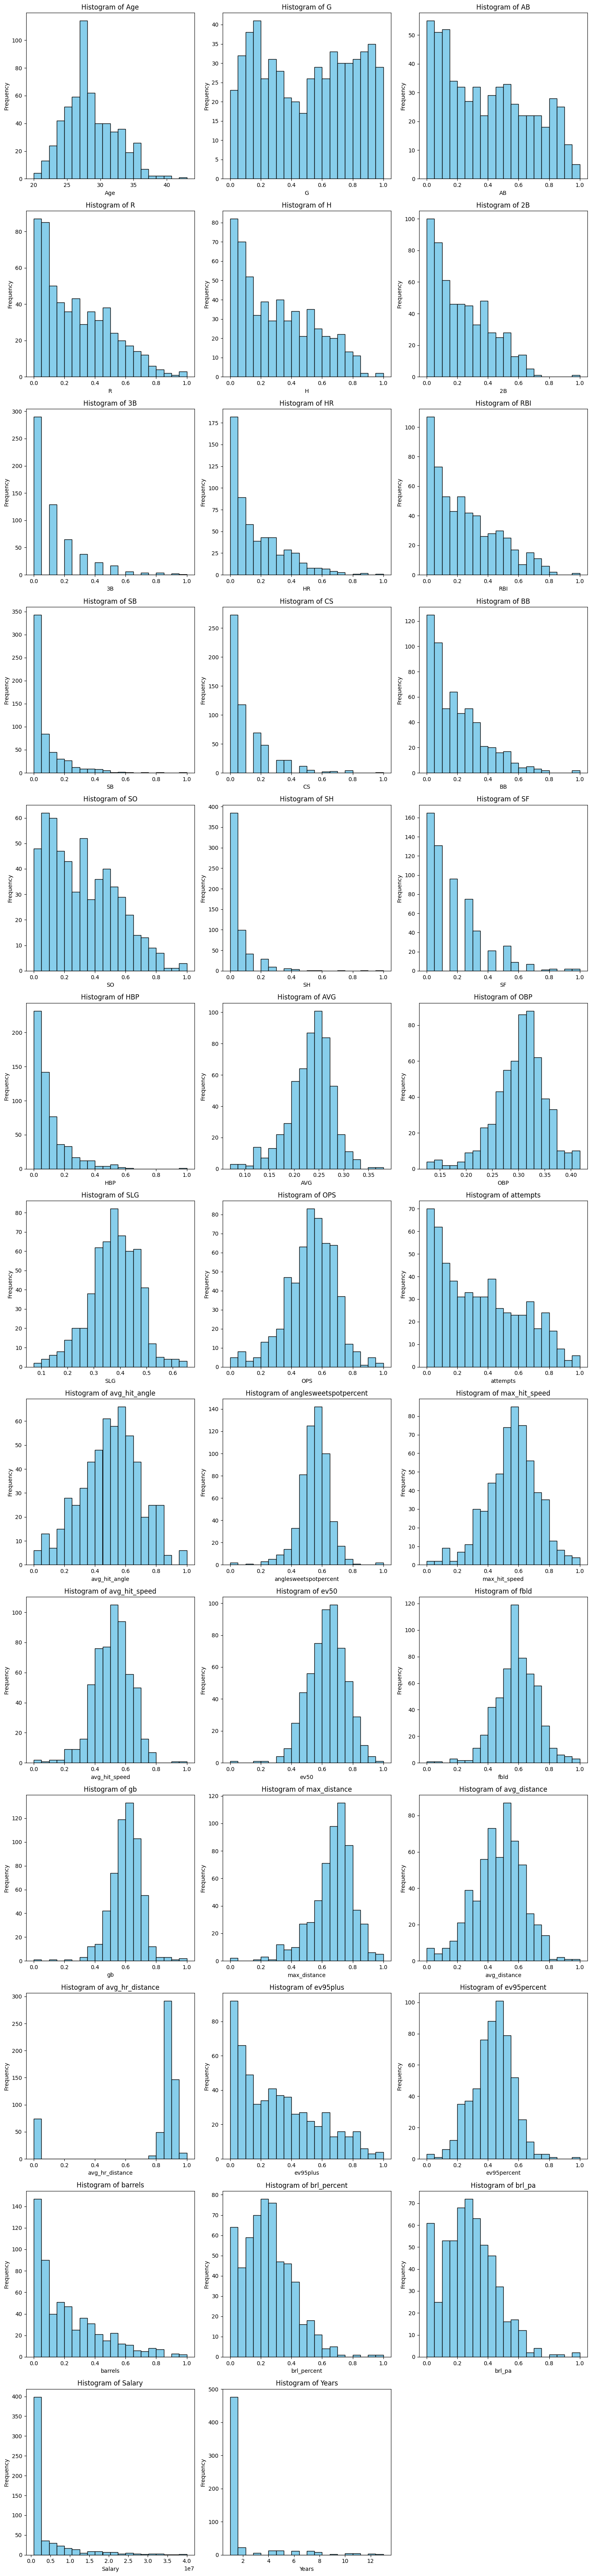

In [ ]:
def display_numeric_histograms(merged_df):
    numeric_columns = [col for col in merged_df_proper.columns if col not in ['Player', 'Team_x', 'names_stripped_lower'] and merged_df_proper[col].dtype in ['int64', 'float64']]

    num_rows = (len(numeric_columns) + 2) // 3
    num_cols = min(len(numeric_columns), 3)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

    if num_rows == 1 and num_cols == 1:
        axes = [axes]
    elif num_rows == 1:
        axes = axes.reshape(1, -1)
    elif num_cols == 1:
        axes = axes.reshape(-1, 1)

    for i, column in enumerate(numeric_columns):
        ax = axes[i // num_cols, i % num_cols]
        ax.hist(merged_df_proper[column], bins=20, color='skyblue', edgecolor='black')
        ax.set_title(f'Histogram of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    for j in range(len(numeric_columns), num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])

    plt.tight_layout()
    plt.show()

display_numeric_histograms(merged_df_proper)

**Getting ready for training**

In [ ]:
from sklearn.model_selection import train_test_split

def convert_salary_to_numeric(df, salary_column):

    df[salary_column] = df[salary_column].replace('[\$,]', '', regex=True).astype(float)
    return df


merged_df_proper = convert_salary_to_numeric(merged_df_proper, "Salary")

def split_train_test_data(df, test_size=0.2, random_state=None):

    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    return train_df, test_df

train_df, test_df = split_train_test_data(merged_df_proper, test_size=0.2, random_state=42)

cols_to_drop = ['Team_x', 'Pos', 'names_stripped_lower', 'player_id', 'Team_y', 'Position', 'Total Value', 'Years', 'Player']

merged_df_proper_useful_columns = merged_df_proper.drop(columns=cols_to_drop, errors='ignore')

mean_salary = merged_df_proper_useful_columns['Salary'].mean()


for index, row in merged_df_proper_useful_columns.iterrows():
    if row['Salary'] == 720000:
        # Generate a random integer between 720000 and the mean salary
        random_salary = np.random.randint(720000, (mean_salary*1.3))
        # Update the 'Salary' attribute with the new random salary
        merged_df_proper_useful_columns.at[index, 'Salary'] = random_salary

print(merged_df_proper_useful_columns)

Train_df, Test_df = split_train_test_data(merged_df_proper_useful_columns, 0.2, 42)
print(Train_df)
print(Test_df)

     Age         G        AB         R         H        2B   3B        HR  \
0     34  0.566038  0.396084  0.335878  0.319048  0.152542  0.1  0.148148   
1     31  0.647799  0.543675  0.603053  0.461905  0.271186  0.0  0.685185   
2     32  0.867925  0.611446  0.450382  0.466667  0.355932  0.2  0.240741   
3     27  0.157233  0.045181  0.045802  0.033333  0.033898  0.0  0.000000   
4     26  0.949686  0.876506  0.641221  0.771429  0.525424  0.1  0.370370   
..   ...       ...       ...       ...       ...       ...  ...       ...   
574   28  0.911950  0.689759  0.458015  0.504762  0.355932  0.4  0.166667   
575   23  0.509434  0.426205  0.290076  0.304762  0.288136  0.0  0.166667   
576   30  0.320755  0.212349  0.122137  0.171429  0.118644  0.0  0.018519   
577   24  0.415094  0.397590  0.305344  0.338095  0.338983  0.1  0.259259   
578   28  0.685535  0.323795  0.129771  0.209524  0.152542  0.0  0.129630   

          RBI        SB  ...  Team_x_TEX  Team_x_TOR  Team_x_WAS  Pos_1B  \

**GETTING ORIGINAL DF READY FOR TRAINING (OUTLIERS)**

In [ ]:
from sklearn.model_selection import train_test_split

def convert_salary_to_numeric(df, salary_column):

    df[salary_column] = df[salary_column].replace('[\$,]', '', regex=True).astype(float)
    return df


merged_df = convert_salary_to_numeric(merged_df, "Salary")

def split_train_test_data(df, test_size=0.2, random_state=None):

    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    return train_df, test_df

train_df_original, test_df_original = split_train_test_data(merged_df_proper, test_size=0.2, random_state=42)

cols_to_drop = ['Team_x', 'Pos', 'names_stripped_lower', 'player_id', 'Team_y', 'Position', 'Total Value', 'Years', 'Player']

merged_df_useful_columns = merged_df.drop(columns=cols_to_drop, errors='ignore')

mean_salary = merged_df_useful_columns['Salary'].mean()


for index, row in merged_df_useful_columns.iterrows():
    if row['Salary'] == 720000:
        # Generate a random integer between 720000 and the mean salary
        random_salary = np.random.randint(720000, (mean_salary*1.3))
        # Update the 'Salary' attribute with the new random salary
        merged_df_useful_columns.at[index, 'Salary'] = random_salary

print(merged_df_useful_columns)

train_df_original, test_df_original = split_train_test_data(merged_df_useful_columns, 0.2, 42)
poly_train = train_df_original
poly_test = test_df_original
print(train_df_original)
print(test_df_original)

     Age    G   AB   R   H  2B  3B  HR  RBI  SB  ...  Team_x_TEX  Team_x_TOR  \
0     36   54  133  15  22   4   0   5   15   0  ...       False       False   
1     34   93  269  44  68   9   1   8   36   6  ...       False       False   
2     31  106  367  79  98  16   0  37   75   3  ...       False       False   
3     34    8   15   1   1   1   0   0    0   0  ...       False       False   
4     27    9   18   4   8   0   0   2    9   0  ...       False       False   
..   ...  ...  ...  ..  ..  ..  ..  ..  ...  ..  ...         ...         ...   
627   23   84  289  38  65  17   0   9   34   5  ...       False       False   
628   30   54  147  16  37   7   0   1   18   4  ...       False       False   
629   29    2    4   0   2   0   0   0    0   0  ...       False       False   
630   24   69  270  40  72  20   1  14   32  14  ...       False       False   
631   28  112  221  17  45   9   0   7   33   5  ...       False       False   

     Team_x_WAS  Pos_1B  Pos_2B  Pos_3B

**Linear regression**

[2.07663684e+06 1.62593117e+07 8.90379692e+06 8.88949596e+06
 7.12833642e+06 2.96790807e+06 4.78890542e+06 6.46464780e+06
 1.88897124e+07 1.63412629e+06 7.13636022e+06 6.88455248e+06
 6.58097923e+06 2.57279837e+06 2.18026973e+06 6.20246833e+06
 1.45243794e+07 9.35497478e+06 7.41330176e+06 6.89202714e+06
 2.11849761e+06 9.12127687e+06 7.40862083e+06 9.75797336e+05
 7.72691409e+05 1.66771018e+05 1.25638251e+07 1.93703456e+06
 1.48322377e+07 4.50050626e+06 1.32547233e+06 1.34264360e+07
 2.51166904e+06 1.44667699e+07 2.75598586e+06 7.47034365e+05
 2.88045508e+05 1.18067083e+06 4.43442217e+06 9.48666643e+06
 4.47868192e+06 9.25011305e+06 3.94610915e+06 7.53334013e+06
 9.48371909e+06 5.63191184e+06 4.18722121e+06 3.62363092e+06
 1.36209161e+06 3.39403482e+06 3.28909062e+06 9.74104431e+04
 3.35633655e+06 2.27675192e+06 7.56806896e+05 4.69019086e+06
 8.97781114e+06 1.86030670e+06 1.13137489e+07 1.30995699e+07
 3.50140690e+06 1.16426929e+07 7.84283387e+06 6.00116699e+06
 5.70430465e+06 7.186548

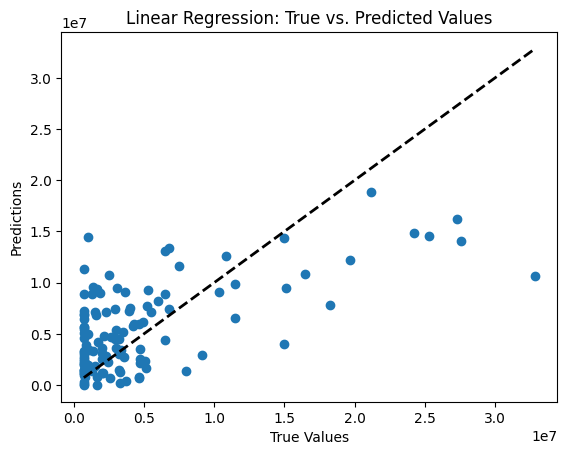

[ 1430498.78207981  9993593.35902182 12411166.56728181   196638.13597392
  2611579.57948616  5469402.6029656   2196639.25507323  5207918.74945744
  1900697.13455861  1697684.69330869  5441486.94913325 16320550.66310966
  1227005.50946413  1629355.28591164  6170392.11272507  4948198.60198789
 20812404.84187112  3284268.85881745  4094391.71475127  1591665.36311369
   595056.78291042  6270129.207624     841606.48454056  3759203.34348928
  1596986.80083942   587407.40794656  4983442.1856925   6044328.50385398
  6781704.36059061  9822642.45429864   461058.87216108  4827193.98292908
  3501641.80610191  3485395.28825001  3411714.41355901  5615983.7947308
 19007300.57403797  7457339.60668984  3398817.81786695  8965183.6454464
  2945719.11683117 11034500.10820098 10545712.80173061  2403286.20860997
 12191275.04210271   800525.62154483  2874806.09755421  2730959.11450497
  1143563.14178265  1668999.05576862 13834767.65059802   446851.04792564
 17226224.0840553   1146861.44176543 10146204.1674698

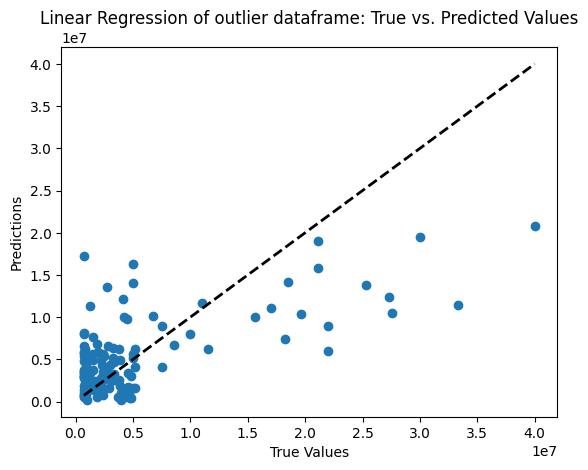

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2s
import matplotlib.pyplot as plt

def train_linear_regression(X_train, y_train):

    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):

    y_pred = model.predict(X_test)

    y_pred_non_negative = np.maximum(y_pred*-1,y_pred)
    print(y_pred_non_negative)
    meanError = mse(y_test, y_pred_non_negative)
    absoluteError = mae(y_test, y_pred_non_negative)
    R2Score = r2s(y_test, y_pred_non_negative)

    metrics = [meanError, absoluteError, R2Score]

    return metrics, y_pred_non_negative

X_train = Train_df.drop('Salary', axis=1)
y_train = Train_df['Salary']
X_test = Test_df.drop('Salary', axis=1)
y_test = Test_df['Salary']
model = train_linear_regression(X_train, y_train)

metrics, y_pred_non_negative = evaluate_model(model, X_test, y_test)


print("Mean Squared Error: ")
print(metrics[0])
print("Mean Absolute Error: ")
print(metrics[1])
print("R2 Score: ")
print(metrics[2])

plt.scatter(y_test, y_pred_non_negative)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Linear Regression: True vs. Predicted Values')
plt.show()

##PERFORMING SAME TESTS ON UNCLEANED DATA

X_train_uncleaned = train_df_original.drop('Salary', axis=1)
y_train_uncleaned = train_df_original['Salary']
X_test_uncleaned = test_df_original.drop('Salary', axis=1)
y_test_uncleaned = test_df_original['Salary']
model = train_linear_regression(X_train_uncleaned, y_train_uncleaned)

metrics, y_pred_non_negative = evaluate_model(model, X_test_uncleaned, y_test_uncleaned)


print("Mean Squared Error: ")
print(metrics[0])
print("Mean Absolute Error: ")
print(metrics[1])
print("R2 Score: ")
print(metrics[2])

plt.scatter(y_test_uncleaned, y_pred_non_negative)
plt.plot([y_test_uncleaned.min(), y_test_uncleaned.max()], [y_test_uncleaned.min(), y_test_uncleaned.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Linear Regression of outlier dataframe: True vs. Predicted Values')
plt.show()



**Polynomial Regression**

Mean Squared Error: 25107425124950.117
Mean Absolute Error: 3760016.48519057
R2 Score: 0.3889353072992182


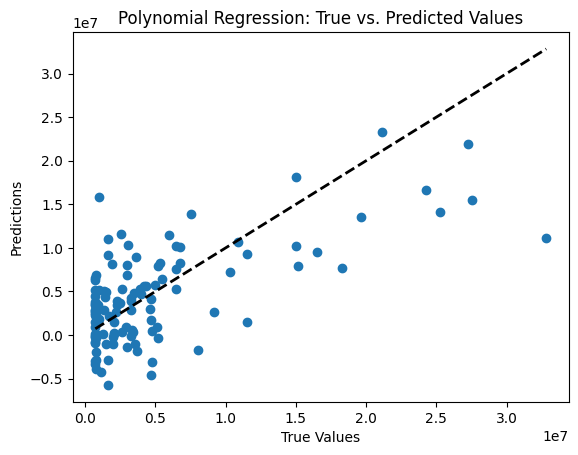

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_polynomial_regression(X_train, y_train, alpha=1.0):
    polynomial_features = PolynomialFeatures(2)
    ridge_regression = Ridge(alpha=alpha)
    model = make_pipeline(polynomial_features, ridge_regression)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2, y_pred

polynomial_model = train_polynomial_regression(X_train, y_train, alpha=1.0)

mse, mae, r2, y_pred = evaluate_model(polynomial_model, X_test, y_test)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Polynomial Regression: True vs. Predicted Values')
plt.show()





**Decision Tree**

Mean Squared Error: 44628823679973.78
Mean Absolute Error: 4274781.129310345
R2 Score: -0.08617663069321746


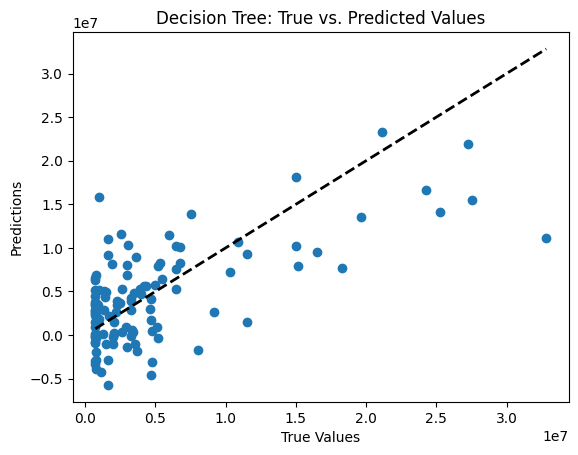

In [ ]:
from sklearn.tree import DecisionTreeRegressor
def train_decision_tree(X_train, y_train):
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    return model

def evaluate_decision_tree(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2


model = train_decision_tree(X_train, y_train)
mse, mae, r2 = evaluate_decision_tree(model, X_test, y_test)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Decision Tree: True vs. Predicted Values')
plt.show()


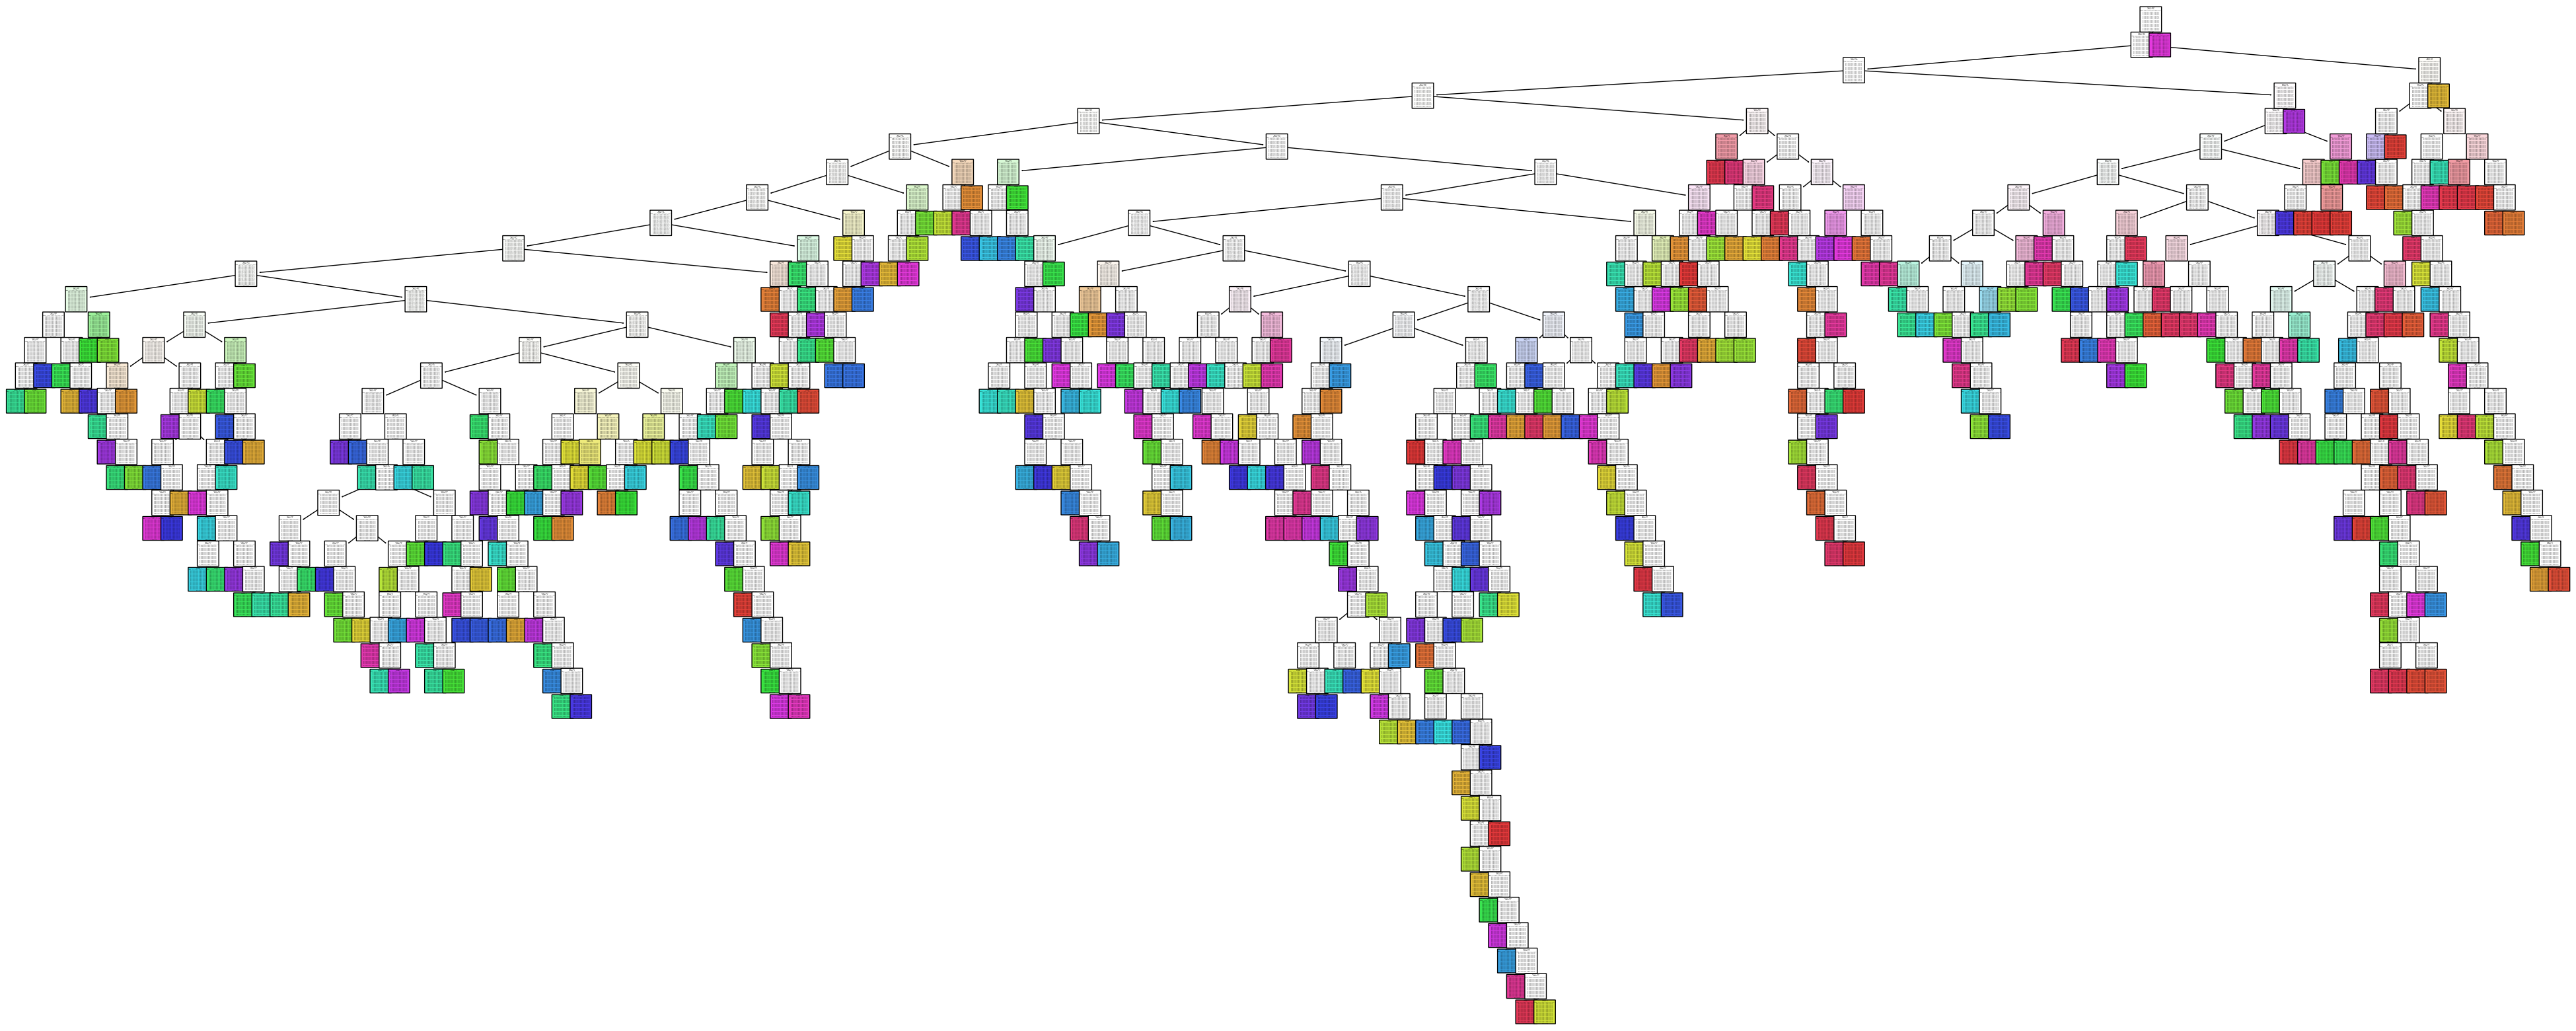

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train, y_train)

plt.figure(figsize=(50, 20))
plot_tree(decision_tree, filled=True, rounded=True)
plt.show()